In [ ]:
!pip install tensorflow tensorflow-gpu matplotlib pandas

In [ ]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

In [ ]:
!pip install keras_vggface

In [ ]:
!pip install keras_applications --no-deps

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
filename = "vggface\Lib\site-packages\keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))

In [3]:
from keras_vggface.vggface import VGGFace

In [4]:
vggface_model = VGGFace(model='resnet50')

1/1 [==============================] - 5s 5s/step


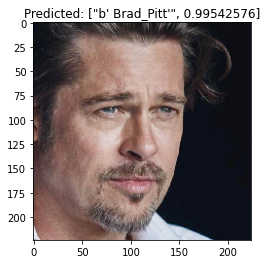

In [5]:
from keras_vggface import utils
from tensorflow.keras.preprocessing import image

img = image.load_img("brad_pitt.jpg", target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2)

preds = vggface_model.predict(x)
plt.title(f"Predicted: {utils.decode_predictions(preds)[0][0]}")
plt.imshow(img)

In [ ]:
! tar -xzf UTKFace.tar.gz 

In [6]:
from pathlib import Path
from collections import Counter

In [7]:
data_folder = Path("UTKFace/")
filenames = list(map(lambda x: x.name, data_folder.glob('*.jpg')))
print(len(filenames))
print(filenames[:3])
# имя файла содержит возраст, индекс пола и расы, перечисленные через нижнее подчеркивание

23708
['100_0_0_20170112213500903.jpg.chip.jpg', '100_0_0_20170112215240346.jpg.chip.jpg', '100_1_0_20170110183726390.jpg.chip.jpg']


In [8]:
# формируем датафрейм с путями и нужными классами
np.random.seed(10)
np.random.shuffle(filenames)
gender_mapping = {0: 'Male', 1: 'Female'}
race_mapping = dict(list(enumerate(('White', 'Black', 'Asian', 'Indian', 'Others'))))
age_labels, gender_labels, race_labels, correct_filenames = [], [], [], []

for filename in filenames:
    if len(filename.split('_')) != 4:
        print(f"Bad filename {filename}")
        continue

    age, gender, race, _ = filename.split('_')
    correct_filenames.append(filename)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)
    
age_labels = np.array(age_labels, dtype=np.float32)
max_age = age_labels.max()
data = {"img_name": correct_filenames, 
        "age": age_labels / max_age, # нормализуем возраст от 0 до 1
        "race": race_labels, 
        "gender": gender_labels}
df = pd.DataFrame(data)
df.head()

Bad filename 61_1_20170109150557335.jpg.chip.jpg
Bad filename 61_1_20170109142408075.jpg.chip.jpg
Bad filename 39_1_20170116174525125.jpg.chip.jpg


,img_name,age,race,gender
0,23_1_2_20170116172910708.jpg.chip.jpg,0.198276,2,1
1,28_0_1_20170113150719161.jpg.chip.jpg,0.241379,1,0
2,26_1_0_20170116234741431.jpg.chip.jpg,0.224138,0,1
3,37_0_3_20170119202516470.jpg.chip.jpg,0.318966,3,0
4,60_0_0_20170109013457906.jpg.chip.jpg,0.517241,0,0


In [9]:
df_split = pd.read_csv("train_val_split_utk.csv", index_col=0).set_index("img_name")
df_split.head()
df = df.set_index("img_name").join(df_split).reset_index()
df_train = df[df["is_train"] == 1]
df_val = df[df["is_train"] != 1]
print(len(df_val), len(df_train))

4759 18946


In [10]:
def decode_labels(race_id, gender_id, age):
    return race_mapping[int(race_id)], gender_mapping[int(gender_id)], int(age*max_age)
def show_face(image, race_id, gender_id, age):
    plt.imshow(image)
    race, gender, age = decode_labels(race_id, gender_id, age)
    plt.title(f"Gender: {gender}, Race: {race}, Age: {age}")

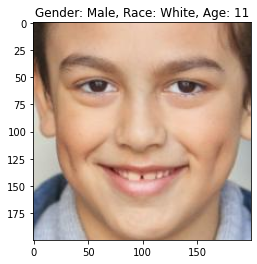

In [11]:
row = df.iloc[np.random.randint(len(df))]
img = plt.imread(str(data_folder / row["img_name"]))
show_face(img, row["race"], row["gender"], row["age"])

In [15]:
vggface_model.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                  

In [16]:
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten").output)
base_model.trainable = False

In [17]:
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model

IMAGE_SIZE = 224
BATCH_SIZE = 128

input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

model_total = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
])

x = model_total(input_layer, training=True)
gender_output = tf.keras.layers.Dense(1, activation='sigmoid', name='gender')(x)
race_output = tf.keras.layers.Dense(5, activation='softmax', name='race')(x)
age_output = tf.keras.layers.Dense(1, activation='sigmoid', name='age')(x)

model_r = tf.keras.Model(inputs=input_layer, outputs=[gender_output, race_output, age_output])

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_input_facenet(image_):
    preprocessed = utils.preprocess_input(image_, version=2)
    return preprocessed

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input_facenet)

In [19]:
train_generator = image_gen.flow_from_dataframe(
        dataframe=df_train,
        class_mode="raw",
        x_col="img_name", y_col=["gender", "race", "age"],
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)

val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="raw",
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)

def split_outputs(generator):
    while True:
        data = next(generator)
        image = data[0]
        labels = np.split(data[1].astype('float32'), 3, axis = 1)
        labels = [labels[0].reshape((len(labels[0]),)),
        labels[1].reshape((len(labels[1]),)),
        labels[2].reshape((len(labels[2]),))]
        yield image, labels

Found 18946 validated image filenames.
Found 4759 validated image filenames.


In [20]:
!pip install livelossplot
from livelossplot import PlotLossesKeras

In [21]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_r.compile(optimizer=optimizer, 
              loss={'gender': 'binary_crossentropy', 'race': 'sparse_categorical_crossentropy', 'age': 'mse'},
              metrics={'gender': 'accuracy', 'race': 'accuracy', 'age': 'mae'},
              loss_weights={"gender" :0.05, "race":0.015, "age": 1})

In [22]:
cpt_filename = "checkpoint_best.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_filename, monitor='val_age_mae', verbose=2, save_best_only=True, mode='min')

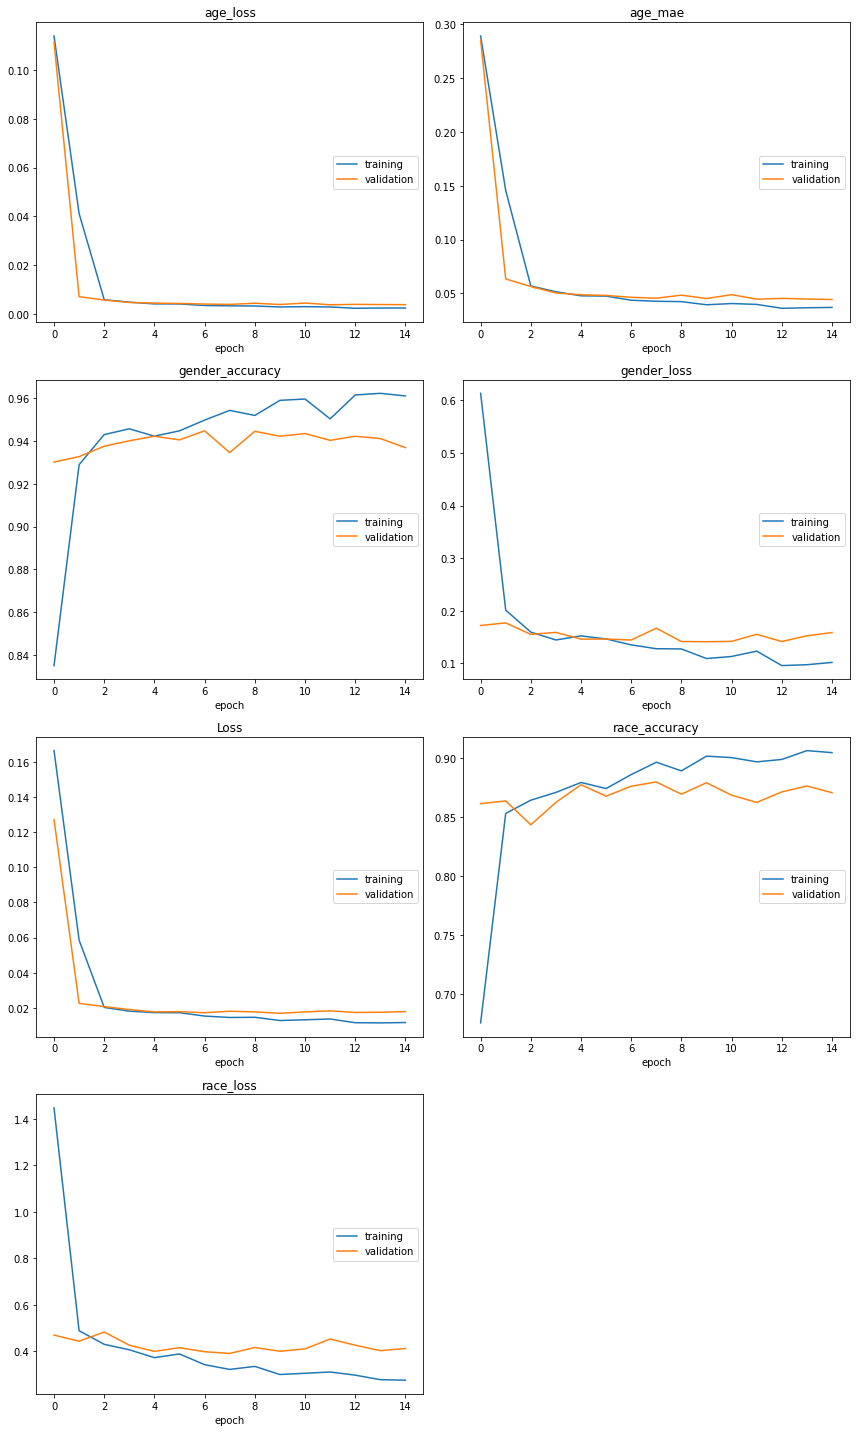

age_loss
	training         	 (min:    0.002, max:    0.114, cur:    0.002)
	validation       	 (min:    0.004, max:    0.111, cur:    0.004)
age_mae
	training         	 (min:    0.036, max:    0.289, cur:    0.037)
	validation       	 (min:    0.044, max:    0.286, cur:    0.044)
gender_accuracy
	training         	 (min:    0.835, max:    0.962, cur:    0.961)
	validation       	 (min:    0.930, max:    0.945, cur:    0.937)
gender_loss
	training         	 (min:    0.096, max:    0.613, cur:    0.102)
	validation       	 (min:    0.141, max:    0.177, cur:    0.159)
Loss
	training         	 (min:    0.011, max:    0.166, cur:    0.012)
	validation       	 (min:    0.017, max:    0.127, cur:    0.018)
race_accuracy
	training         	 (min:    0.675, max:    0.906, cur:    0.905)
	validation       	 (min:    0.843, max:    0.880, cur:    0.871)
race_loss
	training         	 (min:    0.275, max:    1.448, cur:    0.275)
	validation       	 (min:    0.390, max:    0.482, cur:    0.411)

E

In [23]:
model_r.fit(split_outputs(train_generator), epochs=15, validation_data=split_outputs(val_generator),
                    callbacks=[PlotLossesKeras(), checkpoint], steps_per_epoch=50, 
                    validation_steps= len(df_val) // BATCH_SIZE)

In [24]:
from tensorflow.keras.models import load_model

In [25]:
model_multitask = load_model("checkpoint_best.h5")

In [26]:
def deprocess_image(vggface_image):  
    image = np.copy(vggface_image)
    
    image[..., 0] += 91.4953
    image[..., 1] += 103.8827
    image[..., 2] += 131.0912
    image = image[..., ::-1]
    image = np.uint8(image)
    
    return image

In [27]:
def show_faces(images, real_race=None, real_gender=None, real_age=None, 
               predicted_race=None, predicted_gender=None, predicted_age=None):
    plt.figure(figsize=(10,10))
    labels = {"Gender": [predicted_gender, real_gender],
                  "Race": [predicted_race, real_race],
                  "Age": [predicted_age, real_age]}
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(deprocess_image(images[i]))
        real_str = "Real:"
        pred_str = "Pred:"
        correct = True
        for name, (predicted, real) in labels.items():
            if predicted is None:
                continue
            if name == "Age":
                real_age = int(real[i]*int(max_age))
                predicted_age = int(predicted[i]*max_age)
                real_str += f"{real_age}"
                pred_str += f"{predicted_age}"
                if np.abs(predicted_age - real_age) > 6:
                    correct = False

            elif name == "Gender":
                real_gender = int(real[i])
                predicted_gender = int(predicted[i] > 0.5)
                real_str += f"{gender_mapping[real_gender]}, "
                pred_str += f"{gender_mapping[predicted_gender]}, "
                if real_gender != predicted_gender:
                    correct = False
            elif name == "Race":
                real_race = int(real[i])
                predicted_race = np.argmax(predicted[i])
                real_str += f"{race_mapping[real_race]}, "
                pred_str += f"{race_mapping[predicted_race]}, "
                if real_race != predicted_race:
                    correct = False
                
        title_obj = plt.title(f"{real_str}\n{pred_str}")
            
        plt.subplots_adjust(wspace=0.4)
        if not correct:
            plt.setp(title_obj, color='r')

4/4 [==============================] - 2s 113ms/step


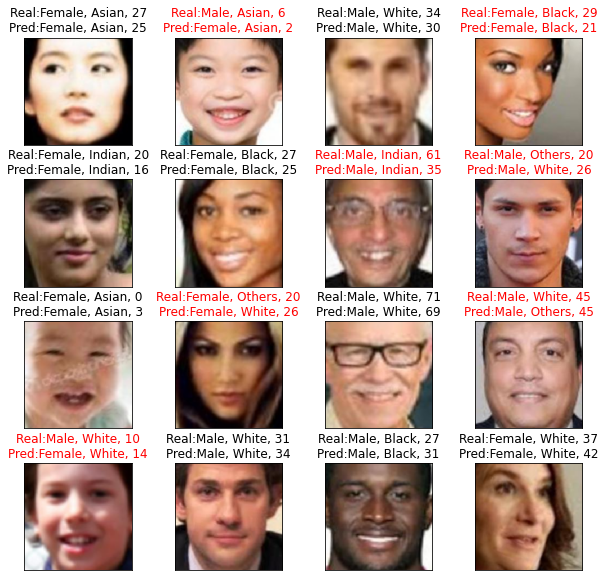

In [28]:
sample_validation_images, sample_validation_labels = next(split_outputs(val_generator))
predicted = model_multitask.predict(sample_validation_images)
show_faces(sample_validation_images, 
           real_gender=sample_validation_labels[0], predicted_gender=predicted[0],
           real_race=sample_validation_labels[1], predicted_race=predicted[1],
           real_age=sample_validation_labels[2].flatten(), predicted_age=predicted[2].flatten(),
           )

1/1 [==============================] - 0s 21ms/step


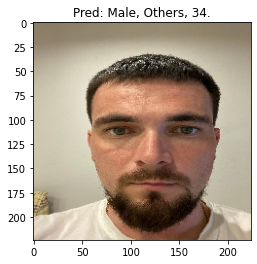

In [30]:
img = image.load_img("me.jpg", target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2) 
predicted_labels = model_r.predict(x)
plt.imshow(img)
gender, race, age = int(predicted_labels[0][0] > 0.5), np.argmax(predicted_labels[1][0]), predicted_labels[2][0]
title_obj = f"Pred: {gender_mapping[gender]}, {race_mapping[race]}, {int(age[0]*max_age)}."
_ = plt.title(title_obj)
# Реальный 27 

1/1 [==============================] - 0s 22ms/step


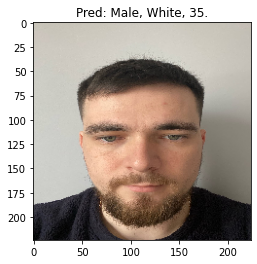

In [33]:
img = image.load_img("me2.jpg", target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2) 
predicted_labels = model_r.predict(x)
plt.imshow(img)
gender, race, age = int(predicted_labels[0][0] > 0.5), np.argmax(predicted_labels[1][0]), predicted_labels[2][0]
title_obj = f"Pred: {gender_mapping[gender]}, {race_mapping[race]}, {int(age[0]*max_age)}."
_ = plt.title(title_obj)
# Реальный 27 